# CS6140 Project - Detection Of Sarcasm In Text

## 1. Data Preprocessing

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
import re
import gensim
import gensim.downloader as api
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression

In [57]:
# Run if running notebook with vectors locally for first time. Files added to gitignore
# glove = api.load('glove-wiki-gigaword-300')
# glove.save('glovevectors.bin')

In [58]:
glove = KeyedVectors.load('glovevectors.bin')

In [59]:
# Run these if not up to date
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [60]:
data = pd.read_csv("train-balanced-sarcasm.csv")

In [61]:
data = data[['label', 'comment', 'subreddit', 'score', 'parent_comment']]

In [62]:
data.head(10)

,label,comment,subreddit,score,parent_comment
0,0,NC and NH.,politics,2,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,nba,-4,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",nfl,3,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,-8,deadass don't kill my buzz
4,0,I could use one of those tools.,MaddenUltimateTeam,6,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",AskReddit,0,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,AskReddit,1,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,FFBraveExvius,2,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",pcmasterrace,1,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,Lollapalooza,2,Probably count Kanye out Since the rest of his...


In [63]:
data.isna().sum()

label              0
comment           53
subreddit          0
score              0
parent_comment     0
dtype: int64

In [64]:
data = data.dropna(axis=0)

In [65]:
data.isna().sum()

label             0
comment           0
subreddit         0
score             0
parent_comment    0
dtype: int64

In [66]:
data['comment_tokens'] = data['comment']
data['comment_tokens'] = data['comment_tokens'].str.lower()
data['comment_tokens'] = data['comment_tokens'].str.replace('can\'t','can not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('\'d',' would',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('wouldn\'t','would not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('couldn\'t','could not',regex = True)
data['comment_tokens'] = data['comment_tokens'].str.replace('[^\w\s]','', regex = True)

In [67]:
data['parent_comment_tokens'] = data['parent_comment']
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.lower()
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('can\'t','can not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('\'d',' would',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('wouldn\'t','would not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('couldn\'t','could not',regex = True)
data['parent_comment_tokens'] = data['parent_comment_tokens'].str.replace('[^\w\s]','', regex = True)

In [68]:
lemma = WordNetLemmatizer()
def apply_lemmatizer(sentence):
    return [lemma.lemmatize(token) for token in wordpunct_tokenize(sentence)]

In [69]:
data["comment_tokens"] = data.comment_tokens.apply(apply_lemmatizer)
data["parent_comment_tokens"] = data.parent_comment_tokens.apply(apply_lemmatizer)

In [70]:
data[["comment", "comment_tokens"]].head(10)

,comment,comment_tokens
0,NC and NH.,"[nc, and, nh]"
1,You do know west teams play against west teams...,"[you, do, know, west, team, play, against, wes..."
2,"They were underdogs earlier today, but since G...","[they, were, underdog, earlier, today, but, si..."
3,"This meme isn't funny none of the ""new york ni...","[this, meme, isnt, funny, none, of, the, new, ..."
4,I could use one of those tools.,"[i, could, use, one, of, those, tool]"
5,"I don't pay attention to her, but as long as s...","[i, dont, pay, attention, to, her, but, a, lon..."
6,Trick or treating in general is just weird...,"[trick, or, treating, in, general, is, just, w..."
7,Blade Mastery+Masamune or GTFO!,"[blade, masterymasamune, or, gtfo]"
8,"You don't have to, you have a good build, buy ...","[you, dont, have, to, you, have, a, good, buil..."
9,I would love to see him at lolla.,"[i, would, love, to, see, him, at, lolla]"


In [71]:
data['comment_tokens'].shape

(1010773,)

In [72]:
data[["parent_comment", "parent_comment_tokens"]].head(10)

,parent_comment,parent_comment_tokens
0,"Yeah, I get that argument. At this point, I'd ...","[yeah, i, get, that, argument, at, this, point..."
1,The blazers and Mavericks (The wests 5 and 6 s...,"[the, blazer, and, maverick, the, west, 5, and..."
2,They're favored to win.,"[theyre, favored, to, win]"
3,deadass don't kill my buzz,"[deadass, dont, kill, my, buzz]"
4,Yep can confirm I saw the tool they use for th...,"[yep, can, confirm, i, saw, the, tool, they, u..."
5,do you find ariana grande sexy ?,"[do, you, find, ariana, grande, sexy]"
6,What's your weird or unsettling Trick or Treat...,"[whats, your, weird, or, unsettling, trick, or..."
7,Probably Sephiroth. I refuse to taint his grea...,"[probably, sephiroth, i, refuse, to, taint, hi..."
8,What to upgrade? I have $500 to spend (mainly ...,"[what, to, upgrade, i, have, 500, to, spend, m..."
9,Probably count Kanye out Since the rest of his...,"[probably, count, kanye, out, since, the, rest..."


In [73]:
data['parent_comment_tokens'].shape

(1010773,)

In [74]:
X = data[['comment_tokens', 'parent_comment_tokens']]

In [75]:
X.head(10)

,comment_tokens,parent_comment_tokens
0,"[nc, and, nh]","[yeah, i, get, that, argument, at, this, point..."
1,"[you, do, know, west, team, play, against, wes...","[the, blazer, and, maverick, the, west, 5, and..."
2,"[they, were, underdog, earlier, today, but, si...","[theyre, favored, to, win]"
3,"[this, meme, isnt, funny, none, of, the, new, ...","[deadass, dont, kill, my, buzz]"
4,"[i, could, use, one, of, those, tool]","[yep, can, confirm, i, saw, the, tool, they, u..."
5,"[i, dont, pay, attention, to, her, but, a, lon...","[do, you, find, ariana, grande, sexy]"
6,"[trick, or, treating, in, general, is, just, w...","[whats, your, weird, or, unsettling, trick, or..."
7,"[blade, masterymasamune, or, gtfo]","[probably, sephiroth, i, refuse, to, taint, hi..."
8,"[you, dont, have, to, you, have, a, good, buil...","[what, to, upgrade, i, have, 500, to, spend, m..."
9,"[i, would, love, to, see, him, at, lolla]","[probably, count, kanye, out, since, the, rest..."


In [76]:
Y = data[['label']]

In [77]:
Y.tail(10)

,label
1010816,1
1010817,1
1010818,1
1010819,1
1010820,1
1010821,1
1010822,1
1010823,1
1010824,1
1010825,1


In [78]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size= 0.6)

In [79]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size = 0.5) 

In [80]:
X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [81]:
y_train = y_train.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [82]:
X_train.head(10)

,comment_tokens,parent_comment_tokens
0,"[imagine, what, it, like, to, live, with, this...","[so, what, im, reading, here, is, it, your, fa..."
1,"[a, for, that, second, question, outdoor, adve...","[film, culture, at, uc, davis, im, proud, to, ..."
2,"[oohhhh, thankfully, he, made, the, comment, a...","[it, a, joke, you, sanctimonious, dickbag]"
3,"[because, that, like, would, not, be, inclusiv...","[they, wanted, to, tackle, too, many, differen..."
4,"[trying, to, top, the, blink, tour, lineup]","[the, wonder, year, fall, tour, soupy, hinted,..."
5,"[they, were, drinking, and, fucking, more, tha...","[til, study, show, that, teen, overestimate, h..."
6,"[and, optimism]","[oh, then, todd, is, the, patron, saint, of, d..."
7,"[they, are, white, hispanic, they, dont, count]","[actually, it, primarily, immigrant, only, spe..."
8,"[i, like, how, the, previous, poster, decides,...","[i, wa, at, the, party, but, youre, right, i, ..."
9,"[that, would, be, considered, a, jamming, devi...","[i, wa, thinking, of, building, a, wifi, ardui..."


In [83]:
len(X_train)

606463

In [84]:
data.shape

(1010773, 7)

In [85]:
# Since comments are already preprocessed and tokenized,
# the vectorizer only needs to take tokens as they are.
tfidfVectorizer = TfidfVectorizer(analyzer=lambda tokens: tokens)
corpus = pd.concat([X_train['comment_tokens'], X_train['parent_comment_tokens']])
tfidfMatrix = tfidfVectorizer.fit_transform(corpus)
vocabulary = tfidfVectorizer.vocabulary_

In [86]:
tfidfMatrix.shape

(1212926, 284779)

In [87]:
# the tfidf matrix has 2021546 rows,
# where the 0 ~ 606462 rows represent original comments in the same order as those in dataset,
# and the 606463 ~ 1212926 rows represent parent comments in the same order as those in dataset;
# and the tfidf matrix has 395961 columns, each represents a word in the vocabulary.
tfidfMatrix

<1212926x284779 sparse matrix of type '<class 'numpy.float64'>'
	with 17857503 stored elements in Compressed Sparse Row format>

In [88]:
# By using the following dict, we can obtain the index of a given word for querying tfidf matrix.
vocabulary

{'imagine': 128065,
 'what': 274367,
 'it': 133638,
 'like': 149272,
 'to': 254036,
 'live': 150285,
 'with': 276621,
 'this': 251665,
 'curse': 70236,
 'a': 19269,
 'for': 101035,
 'that': 250264,
 'second': 223826,
 'question': 204723,
 'outdoor': 185259,
 'adventure': 22243,
 'doe': 80379,
 'summer': 243442,
 'hike': 121500,
 'but': 50969,
 'each': 85170,
 'one': 182651,
 'cost': 66603,
 'money': 166523,
 'oohhhh': 183260,
 'thankfully': 250198,
 'he': 118847,
 'made': 154486,
 'the': 250495,
 'comment': 62991,
 'and': 27276,
 'not': 178235,
 'me': 159606,
 'i': 126295,
 'thought': 251998,
 'artist': 31902,
 'wa': 270761,
 'making': 155405,
 'point': 195712,
 'about': 20302,
 'human': 125089,
 'relationship': 210861,
 'desire': 76175,
 'be': 39263,
 'pleasured': 194993,
 'because': 39613,
 'would': 278089,
 'inclusive': 129214,
 'man': 155927,
 'trying': 258413,
 'top': 254929,
 'blink': 44289,
 'tour': 255582,
 'lineup': 149710,
 'they': 251244,
 'were': 273915,
 'drinking': 82935,

Once we have learned word vectors, to compute the sentence vector of a comment,
first fetch the corresponding row from the tfidf matrix (if it is the i-th original comment, then
it is the i-th row; if it is the i-th parent comment, then it is the (1010773 + i)-th row),
second for each word in the comment find its corresponding tfidf value from the row,
third compute the average of the word vectors weighted by corresponding tfidf values.

In [89]:
tfidfMatrix.shape

(1212926, 284779)

In [90]:
tfidfMatrix[0,249920]

0.0

In [91]:
vocabulary['thats']

250360

In [92]:
tfidfMatrixtest = tfidfVectorizer.transform(pd.concat([X_test['comment_tokens'], X_test['parent_comment_tokens']]))
tfidfMatrixvalid = tfidfVectorizer.transform(pd.concat([X_val['comment_tokens'], X_val['parent_comment_tokens']]))

In [93]:
tfidfMatrixtest.shape

(404310, 284779)

In [94]:
X_test.head(10)

,comment_tokens,parent_comment_tokens
0,[howdoyouhavesoprettyvoicethoholycrap],"[this, is, a, first, for, me, a, cover, of, on..."
1,"[ive, never, heard, of, a, parallel, bible]","[try, a, parallel, bible, maybe, one, with, an..."
2,"[i, saw, this, at, best, buy, but, could, not,...","[ha, anyone, heard, of, the, corsair, k65, lux]"
3,"[so, when, people, now, a, day, say, they, spe...","[that, statement, is, not, accurate, and, is, ..."
4,"[wooooooow, this, sub, is, soooooo, bad, now]","[we, are, getting, a, new, steve, job, movie, ..."
5,"[by, looking, at, the, ground]","[i, think, it, a, lottery, i, can, run, it, fi..."
6,"[voivod, the, outer, limit, frank, black, teen...","[what, 5, album, not, currently, or, easily, a..."
7,"[yeah, because, thug, against, thug, is, equal...","[yeah, i, agree, it, like, in, ww2, you, might..."
8,"[you, would, catch, more, if, you, used, high,...","[bait, the, cop]"
9,"[what, is, the, airspeed, velocity, of, an, un...","[a, lot, of, kevin, morby, it, seems, like]"


In [95]:
vocabulary['for']

101035

In [96]:
tfidfMatrixtest[0, 100573]

0.0

In [97]:
def generate_dataset(X, tfidfmat):
    comment_featurevec = []
    parent_featurevec = []
    
    for index, sample in X.iterrows():
        
        comment_vec = np.zeros(300)
        parent_comment_vec = np.zeros(300)
        comment_tokens = sample['comment_tokens']
        parent_comment_tokens = sample['parent_comment_tokens']
        counter1 = 0
        
        for token in comment_tokens:
            
            if token in glove and token in vocabulary:
                counter1 += 1
                comment_vec += tfidfmat[index, vocabulary[token]] * glove[token]
        
        counter2 = 0
        for token in parent_comment_tokens:
            
            if token in glove and token in vocabulary:
                counter2 += 1 
                parent_comment_vec += tfidfmat[index+len(X), vocabulary[token]] * glove[token]
        
        if counter1 != 0:
            comment_featurevec.append(comment_vec/counter1)
        else:
            comment_featurevec.append(comment_vec)
        
        if counter2 != 0:
            parent_featurevec.append(parent_comment_vec/counter2)
        else:
            parent_featurevec.append(parent_comment_vec)
            
        
    #print(len(comment_featurevec))
    X['comment_weighted_vec'] = comment_featurevec
    X['parent_weighted_vec'] = parent_featurevec
    new_df = pd.DataFrame()
        
    return X
    
    
    

In [98]:
X_train = generate_dataset(X_train, tfidfMatrix)

In [99]:
X_val = generate_dataset(X_val, tfidfMatrixvalid)

In [100]:
X_test = generate_dataset(X_test, tfidfMatrixtest)

In [101]:
X_train = X_train[['comment_weighted_vec', 'parent_weighted_vec']]
X_val = X_val[['comment_weighted_vec', 'parent_weighted_vec']]
X_test = X_test[['comment_weighted_vec', 'parent_weighted_vec']]

In [102]:
def featurize(dataset):
    x = pd.DataFrame(dataset['parent_weighted_vec'].tolist(), columns = [i for i in range(300)])
    y = pd.DataFrame(dataset['comment_weighted_vec'].tolist(), columns = [i for i in range(300, 600)])
    return pd.concat([x, y], axis = 1)

In [103]:
X_train = featurize(X_train)
X_val = featurize(X_val)
X_test = featurize(X_test)

In [104]:
clf = LogisticRegression(max_iter = 500).fit(X_train, y_train.values.ravel())

In [105]:
clf.score(X_test, y_test)

0.5967895921446414

In [106]:
clf.score(X_val, y_val)

0.5971507011946279

In [107]:
clf.predict(X_test.iloc[2].values.reshape(1,-1))

array([0], dtype=int64)

In [108]:
y_test['label']

0         0
1         0
2         0
3         0
4         0
         ..
202150    0
202151    0
202152    0
202153    1
202154    1
Name: label, Length: 202155, dtype: int64

## 2. Models

In [177]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        
        self.z1 = nn.Linear(input_dim, hidden_dim)
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
        
        self.z2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.z3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.relu(self.z1(x))
        out = self.relu(self.z2(out))
        out = self.z3(out)
        return out

In [178]:
input_dim = 600
hidden_dim = 500
output_dim = 2
num_epochs = 50
batch_size = 1000

ff_nn_model = FFNN(input_dim, hidden_dim, output_dim)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ff_nn_model.parameters(), lr=0.001)

In [179]:
train_losses = []
for epoch in range(num_epochs):
    print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    inpt = []
    size = int(X_train.shape[0])
    for index, row in X_train.iterrows():
        inpt.append(row)
        if (index + 1) % batch_size == 0:
            output = ff_nn_model(torch.Tensor(inpt))
            label = torch.tensor(list(y_train['label'].values)[index:index+batch_size])
            print(index, end="\r")
            if len(label) < batch_size:
               break
            optimizer.zero_grad() 
            loss = loss_fn(output, label)
        
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            inpt = []
    if epoch > 1 and train_losses[- 1] - train_loss < 0.0001:
      break
    train_losses.append(train_loss)
    print(train_losses[epoch])

Epoch completed: 1
419.4007030725479
Epoch completed: 2
419.28887033462524
Epoch completed: 3
418.2347935438156
Epoch completed: 4
416.05329316854477
Epoch completed: 5
413.4948219060898
Epoch completed: 6
410.9097588658333
Epoch completed: 7
407.6326880455017
Epoch completed: 8
404.20346492528915
Epoch completed: 9
400.7679908275604
Epoch completed: 10
396.6848369240761
Epoch completed: 11
392.12132263183594
Epoch completed: 12
387.5404767394066
Epoch completed: 13
383.39297461509705
Epoch completed: 14
379.2962591648102
Epoch completed: 15
375.0280290842056
Epoch completed: 16
371.11839389801025
Epoch completed: 17
367.5978265404701
Epoch completed: 18
364.1311864852905
Epoch completed: 19
360.8295074105263
Epoch completed: 20
358.1400372982025
Epoch completed: 21
355.3358822464943
Epoch completed: 22
353.47171515226364
Epoch completed: 23
349.8179873228073
Epoch completed: 24
347.23217779397964
Epoch completed: 25
344.4728235602379
Epoch completed: 26
342.63604801893234
Epoch comple

KeyboardInterrupt: 

In [180]:
from sklearn.metrics import classification_report
preds = []
labels = torch.tensor(list(y_val['label'].values))
with torch.no_grad():
    for index, row in X_val.iterrows():
        output = ff_nn_model(torch.Tensor(row))
        preds.append(torch.argmax(output, dim=0))
        
print(len(labels), len(preds))
print(classification_report(labels, preds))

202155 202155
              precision    recall  f1-score   support

           0       0.50      0.51      0.51    100926
           1       0.50      0.49      0.50    101229

    accuracy                           0.50    202155
   macro avg       0.50      0.50      0.50    202155
weighted avg       0.50      0.50      0.50    202155



In [183]:
from sklearn.metrics import classification_report
preds = []
labels = torch.tensor(list(y_test['label'].values))
with torch.no_grad():
    for index, row in X_test.iterrows():
        output = ff_nn_model(torch.Tensor(row))
        preds.append(torch.argmax(output, dim=0))
        
print(len(labels), len(preds))
print(classification_report(labels, preds))

202155 202155
              precision    recall  f1-score   support

           0       0.50      0.51      0.51    101318
           1       0.50      0.50      0.50    100837

    accuracy                           0.50    202155
   macro avg       0.50      0.50      0.50    202155
weighted avg       0.50      0.50      0.50    202155



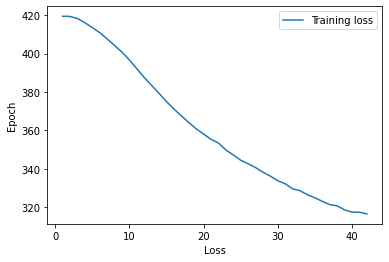

In [182]:
plt.plot(list(range(1,43)), train_losses, label = "Training loss")
plt.legend()
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.show()

## 3. Evaluation